# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Цель исследования:** установить нужные границы характеристик в данных, чтобы иметь возможность находить аномалии и мошенническую деятельность в базе недвижимости.
    

**Содержание**
    
    
1. [Изучение данных из файла](#open)
    
    
2. [Предобработка данных](#preproc)
     
    
3. [Предварительные расчёты и добавление результатов в таблицу](#pred)


4. [Исследовательский анализ данных](#research)
    * [4.1 Параметры площадь, цена, число комнат и высота потолков](#ans1)
    * [4.2 Время продажи квартиры](#ans2)
    * [4.3 Отсев выбивающихся значений](#ans3)
    * [4.4 Факторный анализ стоимости квартиры](#ans4)
    * [4.5 Анализ стоимости по географическому признаку](#ans5)
    * [4.6 Анализ изменения стоимости по удаленности от центра](#ans6)
    * [4.7 Анализ данных в центральной зоне Санкт-Петербурга](#ans7)
    
    
4. [Общий вывод](#summary)

<a id="open"></a>
## 1. Изучение данных из файла

In [2]:
# Импортируем библиотеки

import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

**Описание данных:**

`airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)<br>
`balcony` — число балконов<br>
`ceiling_height` — высота потолков (м)<br>
`cityCenters_nearest` — расстояние до центра города (м)<br>
`days_exposition` — сколько дней было размещено объявление (от публикации до снятия)<br>
`first_day_exposition` — дата публикации<br>
`floor` — этаж<br>
`floors_total` — всего этажей в доме<br>
`is_apartment` — апартаменты (булев тип)<br>
`kitchen_area` — площадь кухни в квадратных метрах (м²)<br>
`last_price` — цена на момент снятия с публикации<br>
`living_area` — жилая площадь в квадратных метрах (м²)<br>
`locality_name` — название населённого пункта<br>
`open_plan` — свободная планировка (булев тип)<br>
`parks_around3000` — число парков в радиусе 3 км<br>
`parks_nearest` — расстояние до ближайшего парка (м)<br>
`ponds_around3000` — число водоёмов в радиусе 3 км<br>
`ponds_nearest` — расстояние до ближайшего водоёма (м)<br>
`rooms` — число комнат<br>
`studio` — квартира-студия (булев тип)<br>
`total_area` — площадь квартиры в квадратных метрах (м²)<br>
`total_images` — число фотографий квартиры в объявлении

In [3]:
# Изучаем таблицу

data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t' )
display(data.head(10))
data.tail(10)
data.sample(5)
data.info()
data.describe().T

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,False,25.00,nan,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,nan
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,nan,11.00,18.60,1,NaN,False,False,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,nan,0.00,nan,81.00
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,nan,5.00,34.30,4,NaN,False,False,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,nan,14.00,nan,9,NaN,False,False,nan,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,False,False,41.00,nan,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00
5,10,"2,890,000.00",30.40,2018-09-10T00:00:00,1,nan,12.00,14.40,5,NaN,False,False,9.10,nan,городской посёлок Янино-1,nan,nan,nan,nan,nan,nan,55.00
6,6,"3,700,000.00",37.30,2017-11-02T00:00:00,1,nan,26.00,10.60,6,NaN,False,False,14.40,1.00,посёлок Парголово,"52,996.00","19,143.00",0.00,nan,0.00,nan,155.00
7,5,"7,915,000.00",71.60,2019-04-18T00:00:00,2,nan,24.00,nan,22,NaN,False,False,18.90,2.00,Санкт-Петербург,"23,982.00","11,634.00",0.00,nan,0.00,nan,nan
8,20,"2,900,000.00",33.16,2018-05-23T00:00:00,1,nan,27.00,15.43,26,NaN,False,False,8.81,nan,посёлок Мурино,nan,nan,nan,nan,nan,nan,189.00
9,18,"5,400,000.00",61.00,2017-02-26T00:00:00,3,2.50,9.00,43.60,7,NaN,False,False,6.50,2.00,Санкт-Петербург,"50,898.00","15,008.00",0.00,nan,0.00,nan,289.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,count,mean,std,min,25%,50%,75%,max
total_images,"23,699.00",9.86,5.68,0.00,6.00,9.00,14.00,50.00
last_price,"23,699.00","6,541,548.77","10,887,013.27","12,190.00","3,400,000.00","4,650,000.00","6,800,000.00","763,000,000.00"
total_area,"23,699.00",60.35,35.65,12.00,40.00,52.00,69.90,900.00
rooms,"23,699.00",2.07,1.08,0.00,1.00,2.00,3.00,19.00
ceiling_height,"14,504.00",2.77,1.26,1.00,2.52,2.65,2.80,100.00
floors_total,"23,613.00",10.67,6.60,1.00,5.00,9.00,16.00,60.00
living_area,"21,796.00",34.46,22.03,2.00,18.60,30.00,42.30,409.70
floor,"23,699.00",5.89,4.89,1.00,2.00,4.00,8.00,33.00
kitchen_area,"21,421.00",10.57,5.91,1.30,7.00,9.10,12.00,112.00
balcony,"12,180.00",1.15,1.07,0.00,0.00,1.00,2.00,5.00


### Вывод

Данные открыты и изучены.

Поле cityCenters_nearest нуждается в переименовании.

Найдены пропуски в полях: 
* ceiling_height
* floors_total
* living_area
* is_apartment
* kitchen_area
* balcony
* locality_name
* airports_nearest
* cityCenters_nearest
* parks_around3000
* parks_nearest
* ponds_around3000
* ponds_nearest
* days_exposition

Некоректные типы данных: 
* Поле first_day_exposition имеет текстовый формат, желательно преобразовать в datetime и округлить до дней.
* Поле is_apartment имеет текстовый формат, желательно преобразовать в bool.
* Поле balcony (количество балконов) имеет дробный формат, желательно преобразовать в int.
* Поле floors_total (количество этажей) имеет дробный формат, желательно преобразовать в int.
* Поле parks_around3000 (число парков в радиусе 3 км) имеет дробный формат, желательно преобразовать в int.
* Поле ponds_around3000 (число водоёмов в радиусе 3 км) имеет дробный формат, желательно преобразовать в int.
* Поле days_exposition (время жизни объявления в днях) имеет дробный формат, желательно преобразовать в int.

У всех числовых полей имеет смысл снизить битность, так как в данных нет слишком больших чисел и мы можем сэкономить память компьютера.

Общее количество строк в таблице: 23699. Этого должно хватить для целей исследования, но требуется предобработка данных.

<a id="preproc"></a>
## 2. Предобработка данных

Переименуем поле cityCenters_nearest

In [4]:
data = data.rename(columns = {'cityCenters_nearest':'city_centers_nearest'})
# data.info()

Заполним пропуски в данных. 

В поле `ceiling_height`,  слишком много пропусков (39% от всех записей), чтобы их заполнять - по остаточным значениям нельзя определить пропущенные значения с достаточной достоверностью.
Поправка: но поскольку разброс значений небольшой заполним медианой.

Пропуски в `kitchen_area` расчитаем , как разницу между total_area и living_area. Оставшиеся после этого пустые значения заполним среднеарифметической площадью.

Пропуски в поле `living_area` расчитаем, как разницу между total_area и kitchen_area. Оставшиеся после этого пустые значения заполним среднеарифметической площадью.

В полях `floors_total` и `days_exposition` пропусков не так много (1% и 13% соответственно, от всех записей), заполним их медианным методом.
Поправка: В поле `floors_total` заполнять пропуски не будем, чтобы не получилось расхождение с данными по текущему этажу. 
В поле `days_exposition` заполнять пропуски также не будем, разброс значений слишком большой. 

В поле `is_apartment` заполним пропуски на False, вероятнее всего, эти квартиры не являются аппартаментами.

В поле `balcony`, вероятно не указаны отсутствующие балконы, заменим их на 0

В полях `parks_around3000`, `ponds_around3000`, вероятно не указаны соответствующие объекты, так как их нет в этом радиусе, заменим их на 0.

Пропуски в `locality_name` заменим на значение "Неизвестно".

Все пропуски в полях выше  могли возникнуть из-за человеческого фактора, вероятно хозяева объявлений поленились их заполнить или не владели информацией.

Пропуски в полях `airports_nearest`, `cityCenters_nearest`, `parks_nearest`, `ponds_nearest` заполнить не получится, оставим их как есть. Пропуски в этих полях появились скорее всего из-за отсутствия координат в данных, например в следствии неверно указанного адреса или технической ошибки.



In [5]:
# Заполняем ceiling_height
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
# Заполняем kitchen_area
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area'] - data['living_area'])
# Оставшиеся значения в kitchen_area
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].mean())
# Заполняем living_area
data['living_area'] = data['living_area'].fillna(data['total_area'] - data['kitchen_area'])
# Оставшиеся значения в living_area
data['living_area'] = data['living_area'].fillna(data['living_area'].mean())
# Заполняем days_exposition
data['is_apartment'] = data['is_apartment'].fillna(False)
# Заполняем balcony
data['balcony'] = data['balcony'].fillna(0)
# Заполняем parks_around3000
data['parks_around3000'] = data['parks_around3000'].fillna(0)
# Заполняем ponds_around3000
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
# Заполняем locality_name
data['locality_name'] = data['locality_name'].fillna('Неизвестно')
# Заполняем days_exposition
data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median())

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23613 non-null float64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null float64
locality_name           23699 non-null object
airports_nearest        18157 non-null float64
city_centers_nearest    18180 non-null float64
parks_around3000        23699 non-null float64
parks_nearest           8079 non-null float64
ponds_around3000

Изменим типы данных в соответствии с нашими решениями.

In [6]:
# Меняем текстовую дату на datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S').dt.round('1d')
# Меняем текстовое поле на bool
data['is_apartment'] = data['is_apartment'].astype('bool')
# Меняем дробные поля на int
data['balcony'] = data['balcony'].astype('int8')
data['floors_total'] = data['floors_total'].astype(pd.Int32Dtype())
data['parks_around3000'] = data['parks_around3000'].astype('int32')
data['ponds_around3000'] = data['ponds_around3000'].astype('int32')
data['days_exposition'] = data['days_exposition'].astype('int32')
# Снижаем битность у оставшихся числовых полей
data['last_price'] = data['last_price'].astype('float32')
data['total_area'] = data['total_area'].astype('float32')
data['ceiling_height'] = data['ceiling_height'].astype('float32')
data['rooms'] = data['rooms'].astype('int8')
data['living_area'] = data['living_area'].astype('float32')
data['floor'] = data['floor'].astype('int8')
data['total_images'] = data['total_images'].astype('int8')
data['kitchen_area'] = data['kitchen_area'].astype('float32')
data['airports_nearest'] = data['airports_nearest'].astype('float32')
data['city_centers_nearest'] = data['city_centers_nearest'].astype('float32')
data['parks_nearest'] = data['parks_nearest'].astype('float32')
data['ponds_nearest'] = data['ponds_nearest'].astype('float32')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int8
last_price              23699 non-null float32
total_area              23699 non-null float32
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int8
ceiling_height          23699 non-null float32
floors_total            23613 non-null Int32
living_area             23699 non-null float32
floor                   23699 non-null int8
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float32
balcony                 23699 non-null int8
locality_name           23699 non-null object
airports_nearest        18157 non-null float32
city_centers_nearest    18180 non-null float32
parks_around3000        23699 non-null int32
parks_nearest           8079 non-null float32
ponds_around3000  

### Вывод
Большая часть пропусков в таблице заполнена в соответствии с принятыми на этапе изучения данных решениями, типы данных успешно изменены, использование памяти сокращено почти в 2 раза.

<a id="pred"></a>
## 3. Предварительные расчёты и добавление результатов в таблицу

Расчитаем цену одного квадратного метра во всей приведенной выборке

In [7]:
data['price_1m'] = data['last_price'] / data['total_area']
# data.head(10)

Расчитаем день недели, месяц и год публикации объявления

In [8]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
# data.head(10)

Расчитаем этаж квартиры (варианты — первый, последний, другой)

In [9]:
#Воспользуемся логической индексацией:

data.loc[data['floor'] == 1, 'floor_type'] = 'Первый'
data.loc[(data['floors_total'] == data['floor']) & (data['floor_type'].isna()), 'floor_type'] = 'Последний'
data.loc[data['floor_type'].isna() , 'floor_type'] = 'Другой'
        
# data.query('floors_total == 2')
# data.query('floors_total == 1')
# data.query('floors_total == 3')

Расчитаем соотношение жилой и общей площади, а также отношение площади кухни к общей

In [10]:
data['liv_tot_area'] = data['living_area'] / data['total_area']
data['kitch_tot_area'] = data['kitchen_area'] / data['total_area']
# data.describe()
display(data.head(5))

<a id="research"></a>
## 4. Исследовательский анализ данных

<a id="ans1"></a>
### 4.1 Параметры  площадь, цена, число комнат и высота потолков

<b>Изучим общую площадь квартир (кв.м.):

count   23,699.00
mean        60.35
std         35.65
min         12.00
25%         40.00
50%         52.00
75%         69.90
max        900.00
Name: total_area, dtype: float64

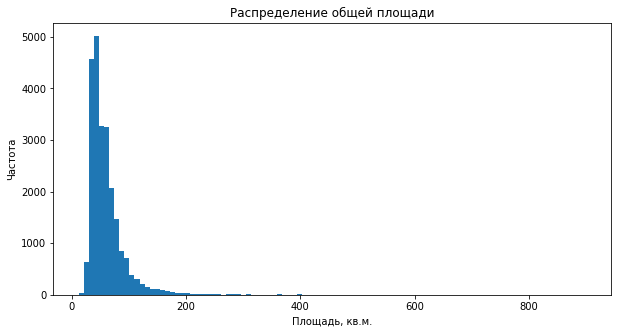

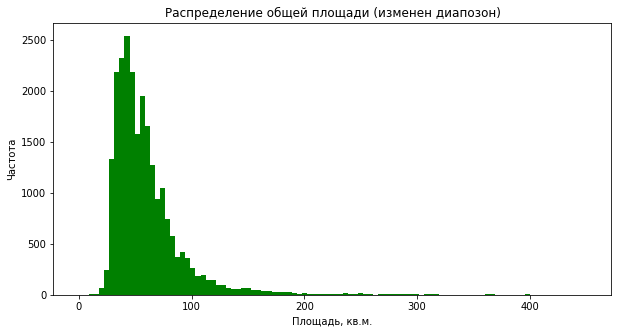

In [11]:
display(data['total_area'].describe())
# Построим гистограмму
hist = data['total_area'].plot(kind='hist', bins=100,  figsize=(10, 5))
hist.set(xlabel='Площадь, кв.м.', ylabel='Частота', title='Распределение общей площади') 
plt.show()
# Перестроим график, отбросив редкие значения
hist = data['total_area'].plot(kind='hist', bins=100,  figsize=(10, 5), range=(0, 450), color="green")
hist.set(xlabel='Площадь, кв.м.', ylabel='Частота', title='Распределение общей площади (изменен диапозон)') 
plt.show()

Результат похож на распределение Пуассона. 

Большая часть значений сосредоточены между 20 и 200, есть редкие значения до 300, единичные выбросы доходят аж до 900, но они столь редки, что не видны на первом графике.

Пик значений приходится на 40-60 кв.м.

<b>Изучим распределение цены (руб.):

count        23,699.00
mean      6,541,548.50
std      10,887,013.00
min          12,190.00
25%       3,400,000.00
50%       4,650,000.00
75%       6,800,000.00
max     763,000,000.00
Name: last_price, dtype: float64

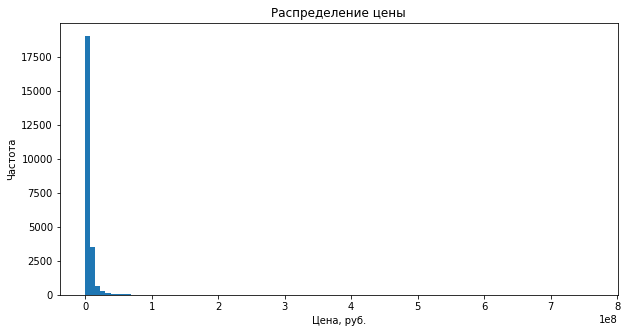

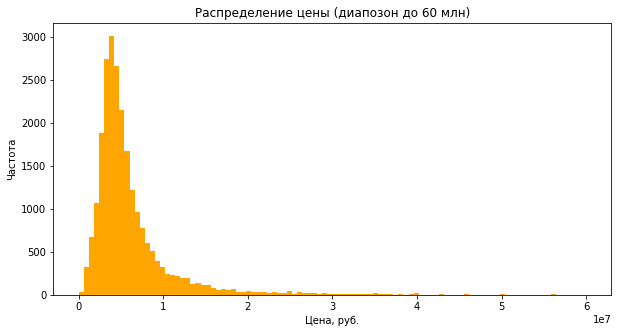

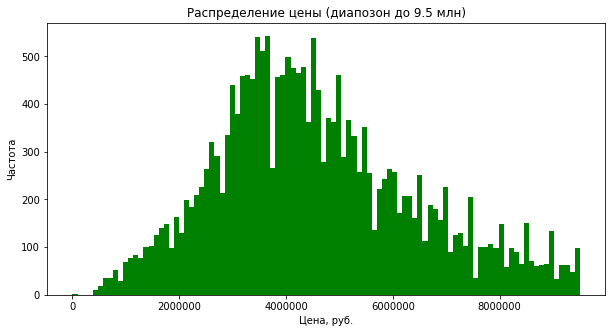

In [12]:
display(data['last_price'].describe())
# Построим гистограмму
hist = data['last_price'].plot(kind='hist', bins=100,  figsize=(10, 5))
hist.set(xlabel='Цена, руб.', ylabel='Частота', title='Распределение цены') 
plt.show()
# Перестроим график, отбросив редкие значения
hist = data['last_price'].plot(kind='hist', bins=100,  figsize=(10, 5), range=(0, 60000000), color="orange")
hist.set(xlabel='Цена, руб.', ylabel='Частота', title='Распределение цены (диапозон до 60 млн)') 
plt.show()
# Перестроим график, отбросив редкие значения
hist = data['last_price'].plot(kind='hist', bins=100,  figsize=(10, 5), range=(0, 9500000), color="green")
hist.set(xlabel='Цена, руб.', ylabel='Частота', title='Распределение цены (диапозон до 9.5 млн)') 
plt.show()

Результат похож на нормальное распределение. Заметны редкие неправдоподобно низкие цены, а частота цен выше 30 млн (3 на втором графике) стремится к 0.
Большая часть значений сосредоточены между 4 млн  и 18 млн., есть редкие значения до 35 млн, другие единичные значения видны и после 35 вплоть до 60 млн. Согласно максимуму, есть значение 763 млн. руб.
Заметно множество локальных пиков и минимумов.
Основной пик значений приходится на 3-6 млн.руб.


<b>Изучим распределение по числу комнат (шт.):

count   23,699.00
mean         2.07
std          1.08
min          0.00
25%          1.00
50%          2.00
75%          3.00
max         19.00
Name: rooms, dtype: float64

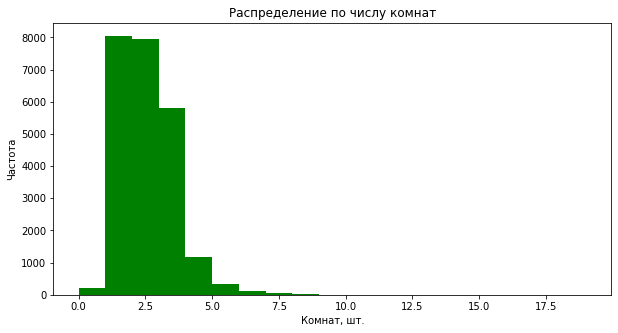

In [13]:
display(data['rooms'].describe())
# Построим гистограмму
hist = data['rooms'].plot(kind='hist', bins=19,  figsize=(10, 5), color="green")
hist.set(xlabel='Комнат, шт.', ylabel='Частота', title='Распределение по числу комнат') 
plt.show()

Результат похоже стремится к нормальному распределению.
Большая часть значений сосредоточены между 1 и 3 комнатами, есть редкие значения от 4 до 8 комнат, другие единичные значения не видны на графике. Согласно максимуму, есть значение 19.
Основной пик приходится на 1-2-х комнатные квартиры.

<b>Изучим высоту потолков (м.):

count   23,699.00
mean         2.72
std          0.99
min          1.00
25%          2.60
50%          2.65
75%          2.70
max        100.00
Name: ceiling_height, dtype: float64

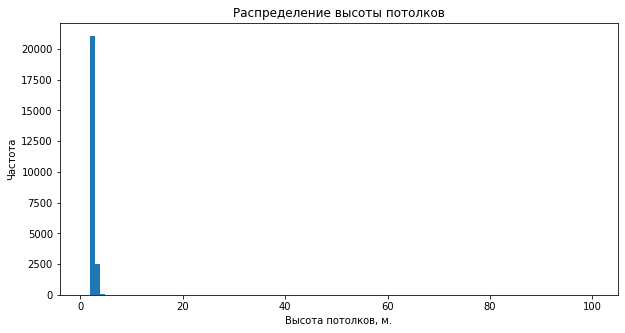

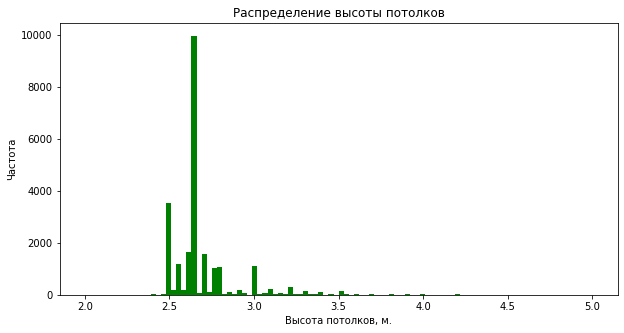

In [14]:
display(data['ceiling_height'].describe())
# Построим гистограмму
hist = data['ceiling_height'].plot(kind='hist', bins=100,  figsize=(10, 5))
hist.set(xlabel='Высота потолков, м.', ylabel='Частота', title='Распределение высоты потолков') 
plt.show()
# Перестроим график, отбросив редкие значения
hist = data['ceiling_height'].plot(kind='hist', bins=100,  figsize=(10, 5), range=(2, 5), color="green")
hist.set(xlabel='Высота потолков, м.', ylabel='Частота', title='Распределение высоты потолков') 
plt.show()

Большая часть значений сосредоточены между 2.5 и 3 м., есть редкие значения от 2 до 2.5 м., а также от 3 до 3.5 м. Единичные значения встречаются вплоть до 4.5, а согласно методу describe, в минимумы и максимумы попали неправдоподобные выбросы 1, 100 м. соответственно.

Пик значений приходится на 2.4 м.

<a id="ans2"></a>
### 4.2 Время продажи квартиры

Изучим время продажи квартиры

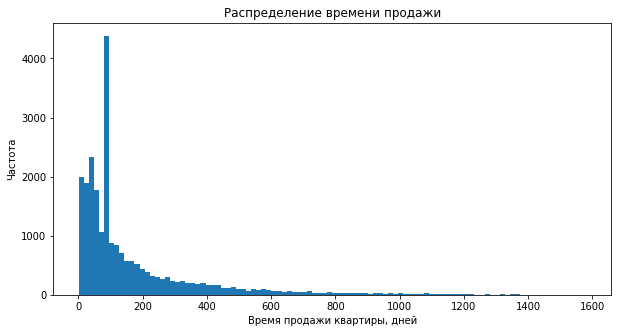

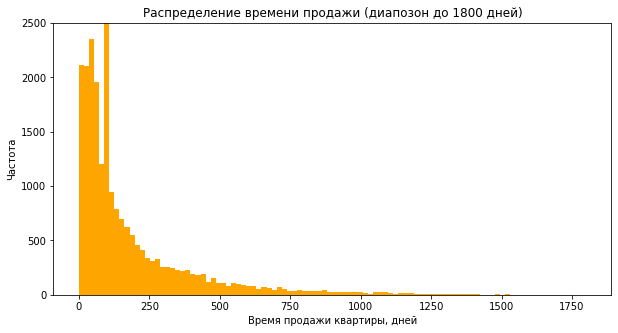

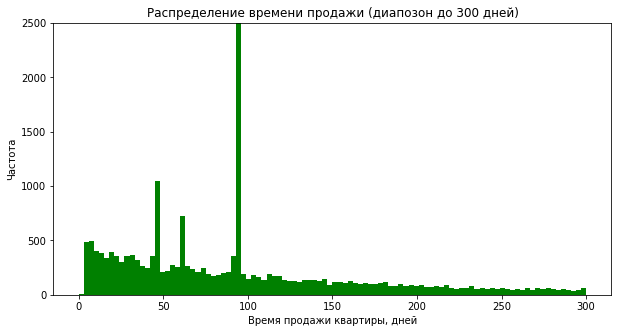

Среднее значение по времени продажи: 169.4 дней.
Медиана времени продажи: 95.0 дней.


In [15]:
# Построим гистограмму
hist = data['days_exposition'].plot(kind='hist', bins=100,  figsize=(10, 5))
hist.set(xlabel='Время продажи квартиры, дней', ylabel='Частота', title='Распределение времени продажи') 
plt.show()
# Перестроим график, отбросив редкие значения
hist = data['days_exposition'].plot(kind='hist', bins=100,  figsize=(10, 5), range=(0, 1800), ylim=(0,2500), color="orange")
hist.set(xlabel='Время продажи квартиры, дней', ylabel='Частота', title='Распределение времени продажи (диапозон до 1800 дней)') 
plt.show()
# Перестроим график, отбросив редкие значения
hist = data['days_exposition'].plot(kind='hist', bins=100,  figsize=(10, 5), range=(0, 300), ylim=(0,2500), color="green")
hist.set(xlabel='Время продажи квартиры, дней', ylabel='Частота', title='Распределение времени продажи (диапозон до 300 дней)') 
plt.show()
# Найдем среднее и медиану
print('Среднее значение по времени продажи:',data['days_exposition'].mean().round(decimals=1),'дней.')
print('Медиана времени продажи:',data['days_exposition'].median().round(decimals=1),'дней.')


* График напоминает распределение Пуассона. 

* Обычно продажа занимает от 0 до 250 дней. 

* Видны несколько странных выбросов на 3-ем графике в значениях около 45, 60 и 95 дней. 

* Если не считать странных пиков, максимум продаж происходит за первый месяц, начиная с 4 дней.

* Быстро продающимися можно считать кваритиры с временем продажи от 5 до 100 дней.

* Если квартира продается дольше 450 дней, можно говорить, что продажа происходит необычно долго.
* Продажу больше 800 дней будем считать аномалиями



<a id="ans3"></a>
### 4.3 Отсев выбивающихся значений

Устраним из данных выявленные выбросы:
* Ограничим площадь квартир значениями от 10 до 300
* Ограничим цену квартир значениями от 400 000 до 350 000 000
* Ограничим кол-во комнат значениями от 1 до 8
* Ограничим высоту потолков значениями от 2 до 4.5 (но учтем, что там могут быть пропуски).
* Ограничим длительность продажи квартир значениями до 1400.
* Также вспомним аномальные пики времени продаж на 45, 60 и 95 днях. Однако записи с такими значениями состваляют значительную часть датафрэйма и их удаление может отрицательно сказаться на исследовании.

In [16]:
good_data = data.query(
('total_area<=300 and total_area>=10 and last_price<=350000000 and last_price>400000 and rooms>=1 and rooms<=8 and (ceiling_height>=2 and ceiling_height<=4.5 or ceiling_height.isna()) and days_exposition<=1400'))

print('Осталось значений:',good_data['total_area'].count(),'(', 100-(good_data['total_area'].count()/data['total_area'].count()).round(2), '%)')

Осталось значений: 23371 ( 99.01 %)


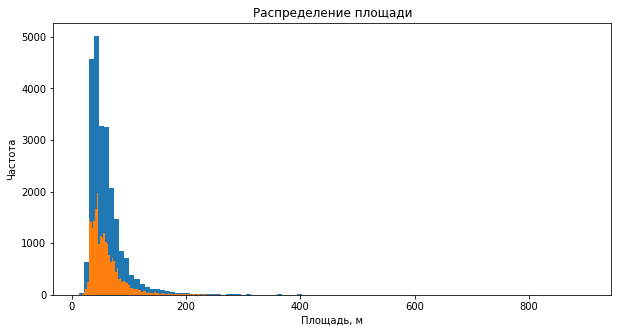

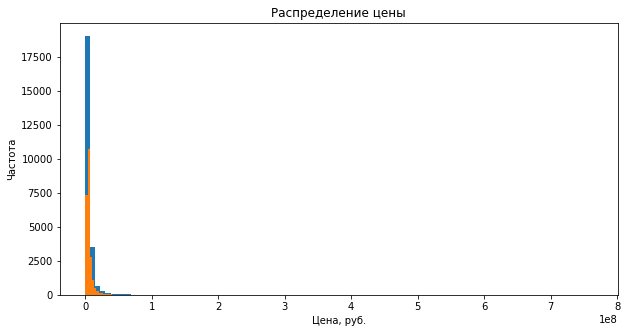

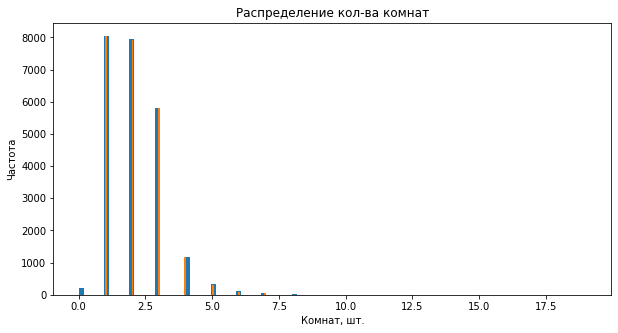

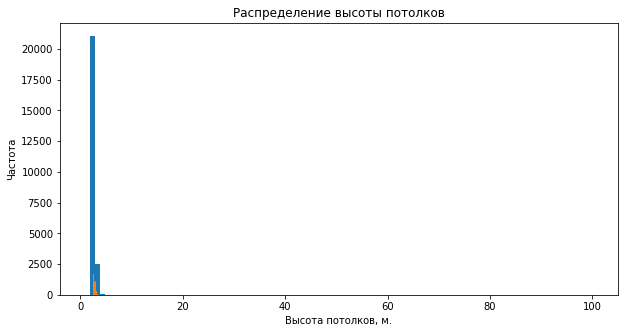

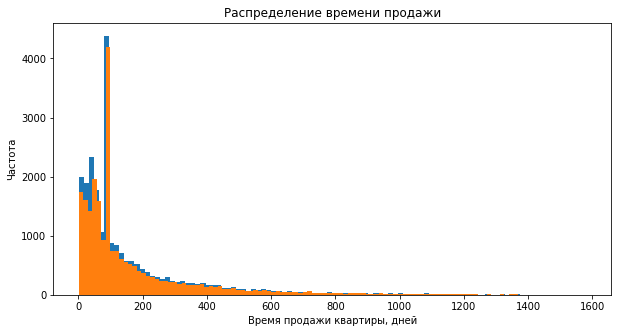

In [17]:
# Посмотрим как изменились графики
hist = data['total_area'].plot(kind='hist', bins=100, figsize=(10, 5))
hist = good_data['total_area'].plot(kind='hist', bins=100,  figsize=(10, 5))
hist.set(xlabel='Площадь, м', ylabel='Частота', title='Распределение площади') 
plt.show()

hist = data['last_price'].plot(kind='hist', bins=100, figsize=(10, 5))
hist = good_data['last_price'].plot(kind='hist', bins=100,  figsize=(10, 5))
hist.set(xlabel='Цена, руб.', ylabel='Частота', title='Распределение цены') 
plt.show()

hist = data['rooms'].plot(kind='hist', bins=100, figsize=(10, 5))
hist = good_data['rooms'].plot(kind='hist', bins=100,  figsize=(10, 5))
hist.set(xlabel='Комнат, шт.', ylabel='Частота', title='Распределение кол-ва комнат') 
plt.show()

hist = data['ceiling_height'].plot(kind='hist', bins=100, figsize=(10, 5))
hist = good_data['ceiling_height'].plot(kind='hist', bins=100,  figsize=(10, 5))
hist.set(xlabel='Высота потолков, м.', ylabel='Частота', title='Распределение высоты потолков') 
plt.show()

hist = data['days_exposition'].plot(kind='hist', bins=100, figsize=(10, 5))
hist = good_data['days_exposition'].plot(kind='hist', bins=100,  figsize=(10, 5))
hist.set(xlabel='Время продажи квартиры, дней', ylabel='Частота', title='Распределение времени продажи') 
plt.show()

В результате фильтрации из данных ушло всего 328 записей (около 1%), это допустимо для продолжения исследования.

Значительнее всего изменилась гистограмма распределения общей площади, график стал больше похож на нормальное распределение. Также исчезли завышенные значения в высоте потолков.

<a id="ans4"></a>
### 4.4 Факторный анализ стоимости квартиры

<b>Посмотрим на корреляцию между стоимостью квартир и их площадью.

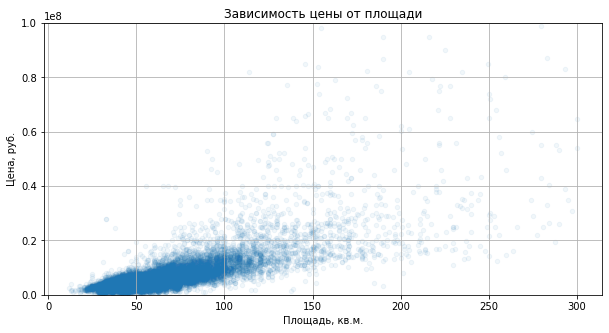

Коэффициент Пирсона: 0.6757852508931267


In [18]:
# Построим диаграмму рассеяния
scat = good_data.plot(x='total_area', y='last_price', kind='scatter', ylim=(0,100000000), figsize=(10, 5), alpha=0.06, grid=True) 
scat.set(xlabel='Площадь, кв.м.', ylabel='Цена, руб.', title='Зависимость цены от площади') 
plt.show()
# Посмотрим на коэффициент корреляции Пирсона
print('Коэффициент Пирсона:',good_data['total_area'].corr(good_data['last_price']))

Положительная сильная зависимость между ценой квартиры и ее площадью обнаружена, коэффициент корреляции 0.68.

<b>Посмотрим на корреляцию между стоимостью квартир и кол-вом комнат.

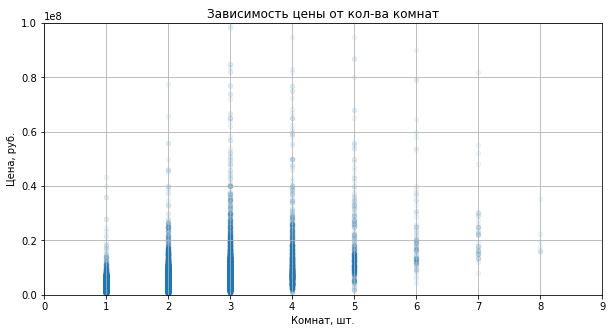

Коэффициент Пирсона: 0.39279307658431245


In [19]:
# Построим диаграмму рассеяния
scat = good_data.plot(x='rooms', y='last_price', kind='scatter', xlim=(0,9), ylim=(0,100000000), figsize=(10, 5), alpha=0.06, grid=True) 
scat.set(xlabel='Комнат, шт.', ylabel='Цена, руб.', title='Зависимость цены от кол-ва комнат') 
plt.show()

# Посмотрим на коэффициент корреляции Пирсона
print('Коэффициент Пирсона:',good_data['rooms'].corr(good_data['last_price']))

Некоторая зависимость между ценой квартиры и кол-вом комнат обнаружена, коэффициент корреляции 0.39.

Среди 1,2,3 комнатных квартир четкая корреляция видна, однако при дальнейшем увеличении кол-ва комнат - цена, как будто, снижается. 

Вероятно, площадь квартиры играет гораздо более важную роль, чем кол-во комнат в ней - ведь комнаты можно создать искусственно, разделив тонкой стеной существующее пространство.

<b>Посмотрим на корреляцию между стоимостью квартир и удалённостью от центра.

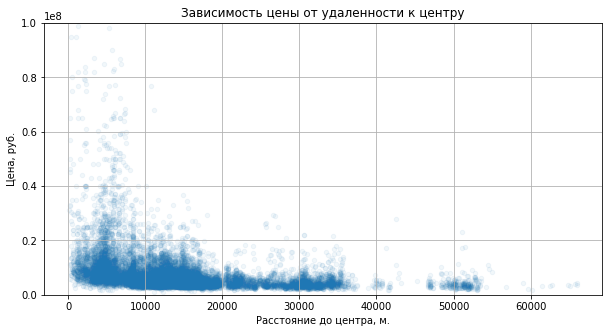

Коэффициент Пирсона: -0.26121816069118636


In [20]:
# Построим диаграмму рассеяния
scat = good_data.plot(x='city_centers_nearest', y='last_price', kind='scatter', ylim=(0,100000000), figsize=(10, 5), alpha=0.06, grid=True) 
scat.set(xlabel='Расстояние до центра, м.', ylabel='Цена, руб.', title='Зависимость цены от удаленности к центру') 
plt.show()

# Посмотрим на коэффициент корреляции Пирсона
print('Коэффициент Пирсона:',good_data['city_centers_nearest'].corr(good_data['last_price']))

Обратная слабая корреляция между ценой квартиры и расстоянием до центра обнаружена, коэффициент корреляции -0.26.

Видно, что самые дорогие квартиры (дороже 30 млн. руб.) расположены в центре и его окрестностях.

Дальше 10 км от центра цена падает уже очень постепенно, так как начинают играть роль другие факторы, а влияние центра ослабевает.

От 37 до 45 км виден некоторый провал в значениях, вероятно здесь мало населенных пунктов или продажи в них редки.

<b>Посмотрим на зависимость между стоимостью квартир и типом этажа.

,floor_type,median_price,mean_price
0,Первый,"3,900,000.00","4,729,003.00"
1,Последний,"4,300,000.00","6,281,997.00"
2,Другой,"4,850,000.00","6,573,719.50"


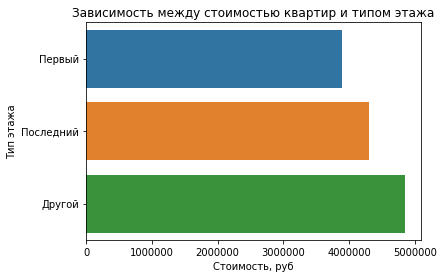

In [21]:
# Воспользуемся сводной таблицей
stat = good_data.pivot_table(index='floor_type', values='last_price',aggfunc=['median','mean'])
stat.columns = ['median_price', 'mean_price']
display(stat.sort_values('median_price').reset_index())

bar = sb.barplot(y='floor_type',x='median_price', data=stat.sort_values('median_price').reset_index())
sb.set(rc = {'figure.figsize':(12,5)})
bar.set(xlabel='Стоимость, руб', ylabel='Тип этажа', title='Зависимость между стоимостью квартир и типом этажа')
plt.show()


По сводной таблице видно, что цена средняя цена квартир ниже всего на первом этаже. На втором месте последний этаж. Средняя стоимость на других этажах выше. 

Медианная цена по типам этажей ведет себя аналогичным образом.

<b>Посмотрим на зависимость между стоимостью квартир и дат размещения.

Посмотрим на зависимость цены от дня недели

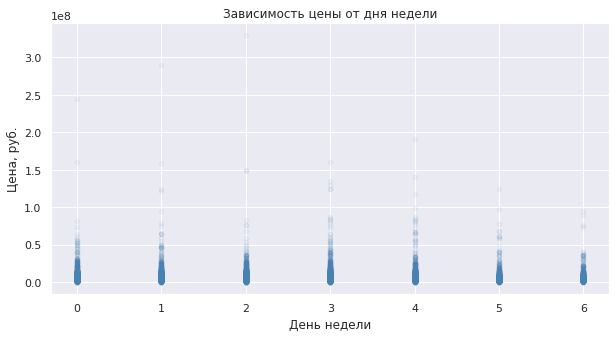

Коэффициент Пирсона: -0.007986301318650734


In [22]:
# Построим диаграмму рассеяния
scat = good_data.plot(x='weekday', y='last_price', kind='scatter', figsize=(10, 5), alpha=0.06, grid=True, color='steelblue') 
scat.set(xlabel='День недели', ylabel='Цена, руб.', title='Зависимость цены от дня недели') 
plt.show()

# Посмотрим на коэффициент корреляции Пирсона
print('Коэффициент Пирсона:',good_data['weekday'].corr(good_data['last_price']))

Корреляция цены объявлений и дня недели отсутствует.

Посмотрим на зависимость цены от месяца объявления

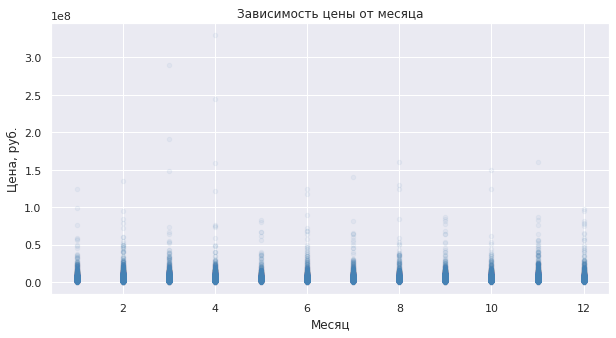

Коэффициент Пирсона: 0.002787608161222048


In [23]:
# Построим диаграмму рассеяния
scat = good_data.plot(x='month', y='last_price', kind='scatter', figsize=(10, 5), alpha=0.06, grid=True, color='steelblue') 
scat.set(xlabel='Месяц', ylabel='Цена, руб.', title='Зависимость цены от месяца') 
plt.show()

# Посмотрим на коэффициент корреляции Пирсона
print('Коэффициент Пирсона:',good_data['month'].corr(good_data['last_price']))

Корреляция цены объявлений и месяца отсутствует.

Посмотрим на зависимость цены от дня недели

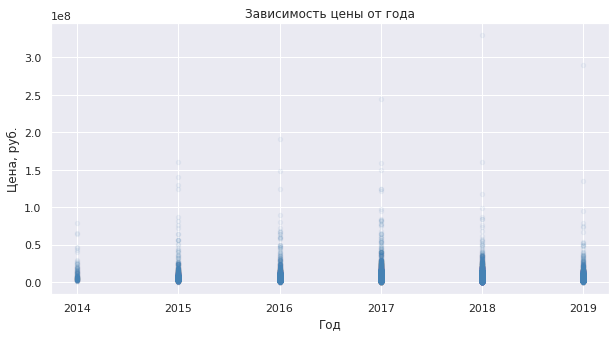

Коэффициент Пирсона: -0.04729235323803907


In [24]:
# Построим диаграмму рассеяния
scat = good_data.plot(x='year', y='last_price', kind='scatter', figsize=(10, 5), alpha=0.06, grid=True, color='steelblue') 
scat.set(xlabel='Год', ylabel='Цена, руб.', title='Зависимость цены от года') 
plt.show()

# Посмотрим на коэффициент корреляции Пирсона
print('Коэффициент Пирсона:',good_data['year'].corr(good_data['last_price']))

Корреляция цены объявлений от года отсутствует.

<a id="ans5"></a>
### 4.5 Анализ стоимости по географическому признаку

<b>Выберем 10 населённых пунктов с наибольшим числом объявлений

In [25]:
biggers_df = good_data.groupby('locality_name').count().sort_values('total_images', ascending = False).head(10)
good_data_biggers = good_data.query('locality_name in @biggers_df.index')
print(good_data_biggers['locality_name'].unique())


['Санкт-Петербург' 'посёлок Шушары' 'посёлок Парголово' 'посёлок Мурино'
 'Пушкин' 'деревня Кудрово' 'Колпино' 'Гатчина' 'Выборг' 'Всеволожск']


<b>Посчитаем среднюю цену квадратного метра в этих населённых пунктах

,locality_name,price_1m
1,Выборг,"58,141.91"
0,Всеволожск,"68,634.25"
2,Гатчина,"68,757.68"
3,Колпино,"75,333.30"
9,посёлок Шушары,"78,405.74"
7,посёлок Мурино,"85,071.28"
8,посёлок Парголово,"90,216.45"
6,деревня Кудрово,"92,297.22"
4,Пушкин,"103,109.27"
5,Санкт-Петербург,"114,188.70"


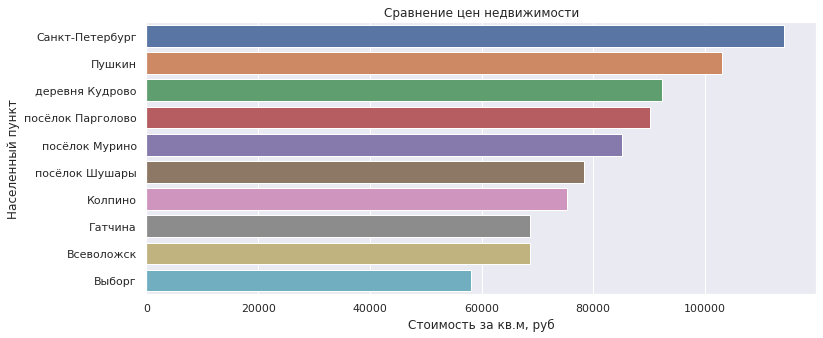

In [26]:
biggers_price = good_data_biggers.pivot_table(index='locality_name', values='price_1m', aggfunc='mean')
biggers_price = biggers_price.reset_index()
display(biggers_price.sort_values('price_1m'))
bar = sb.barplot(y='locality_name',x='price_1m',  data=biggers_price.sort_values('price_1m', ascending=False))
sb.set(rc = {'figure.figsize':(12,5)})
bar.set(xlabel='Стоимость за кв.м, руб', ylabel='Населенный пункт', title='Сравнение цен недвижимости')
plt.show()



Средняя стоимость квадратного метра жилья варьируется в нашей выборке от 58 тыс.р. (Выборг) до 114 тыс.р. (Санкт-Петербург).

<a id="ans6"></a>
### 4.6 Анализ изменения стоимости по удаленности от центра

Выберем все квартиры в СПб

In [27]:
spb = good_data.query('locality_name == "Санкт-Петербург"')
# spb

Добавим столбец с расстоянием до центра в километрах и посчитаем как средняя стоимость квартир меняется по мере удаления от него

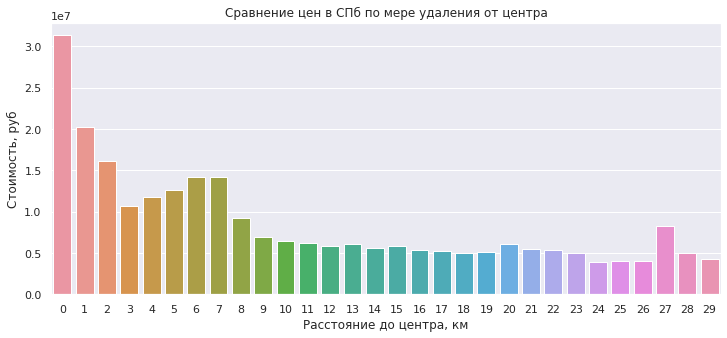

In [36]:
# Добавим столбец и округлим до целых
# spb['city_centers_nearest_km'] = (spb['city_centers_nearest']/1000).round()
# spb['city_centers_nearest_km'] = ((good_data['city_centers_nearest']/1000).round()).where(good_data['locality_name']=='Санкт-Петербург', other='')
spb.loc[spb['locality_name'] == 'Санкт-Петербург', 'city_centers_nearest_km'] = (spb['city_centers_nearest']/1000).round()
avg_price_from_center =  spb.pivot_table(index='city_centers_nearest_km', values='last_price', aggfunc='mean')
avg_price_from_center = avg_price_from_center.reset_index()
avg_price_from_center['city_centers_nearest_km'] = avg_price_from_center['city_centers_nearest_km'].astype('int') 

# Построим график
bar = sb.barplot(x='city_centers_nearest_km',y='last_price',  data=avg_price_from_center.sort_values('last_price', ascending=False))
sb.set(rc = {'figure.figsize':(12,5)})
bar.set(ylabel='Стоимость, руб', xlabel='Расстояние до центра, км', title='Сравнение цен в СПб по мере удаления от центра')
plt.show()

Поведение графика резко меняется после 7го км от центра, после которого начинается спад цены, это и есть центральная зона.

<a id="ans7"></a>
### 4.7 Анализ данных в центральной зоне Санкт-Петербурга

Выделим объявления в центральной зоне

In [28]:
spb_center = spb.query('city_centers_nearest_km <= 7')


<b>Изучим общую площадь квартир (кв.м.):

count   3,444.00
mean       89.04
std        46.34
min        12.00
25%        56.80
50%        78.00
75%       108.40
max       300.00
Name: total_area, dtype: float64

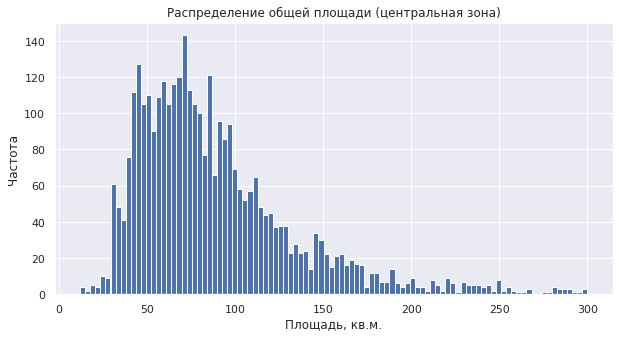

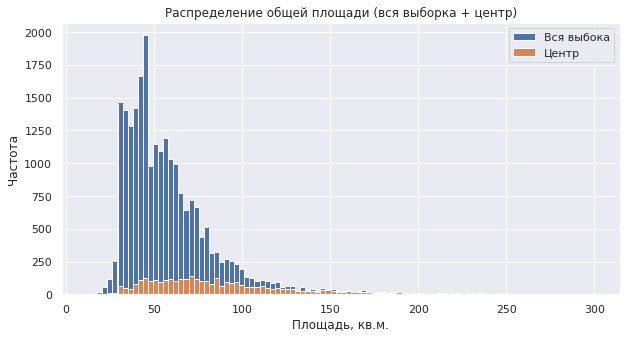

In [29]:
display(spb_center['total_area'].describe())
# Построим гистограмму

hist = spb_center['total_area'].plot(kind='hist', bins=100,  figsize=(10, 5))
hist.set(xlabel='Площадь, кв.м.', ylabel='Частота', title='Распределение общей площади (центральная зона)') 
plt.show()

hist = good_data['total_area'].plot(kind='hist', bins=100,  figsize=(10, 5), legend = True, label='Вся выбока')
hist = spb_center['total_area'].plot(kind='hist', bins=100,  figsize=(10, 5), legend = True, label='Центр')
hist.set(xlabel='Площадь, кв.м.', ylabel='Частота', title='Распределение общей площади (вся выборка + центр)') 
plt.show()


Результат больше похож на нормальное распределение, чем на всей выборке.

Большая часть значений сосредоточены между 20 и 200, есть редкие значения до 300.
Пик значений приходится на 70-80 кв.м, пики смещены вправо относительно всей выборки.

<b>Изучим распределение цены (руб.):

count         3,444.00
mean     13,579,598.00
std      16,456,748.00
min       1,600,000.00
25%       6,650,000.00
50%       9,055,000.00
75%      14,000,000.00
max     330,000,000.00
Name: last_price, dtype: float64

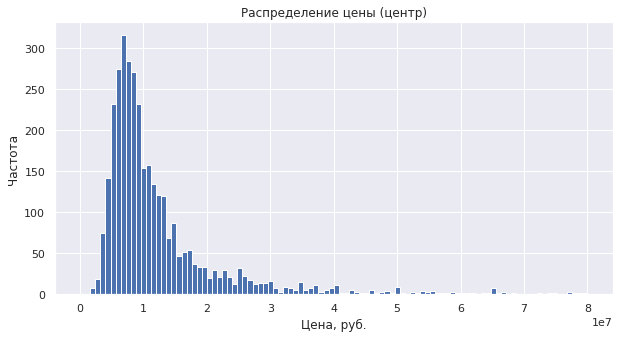

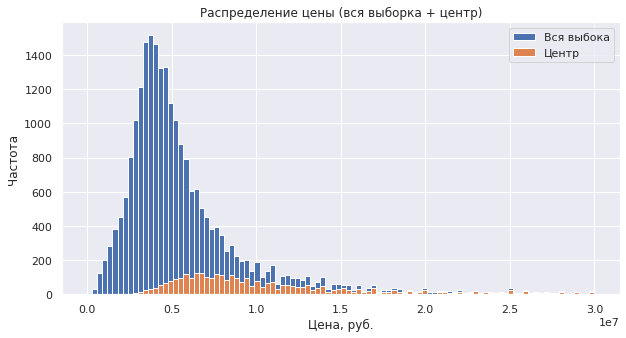

In [30]:
display(spb_center['last_price'].describe())
# Построим гистограмму

hist = spb_center['last_price'].plot(kind='hist', bins=100,  figsize=(10, 5), range=(0, 80000000))
hist.set(xlabel='Цена, руб.', ylabel='Частота', title='Распределение цены (центр)') 
plt.show()

# Сравним со всей выборкой
hist = good_data['last_price'].plot(kind='hist', bins=100,  figsize=(10, 5), range=(0, 30000000), legend = True, label='Вся выбока')
hist = spb_center['last_price'].plot(kind='hist', bins=100,  figsize=(10, 5), range=(0, 30000000), legend = True, label='Центр')
hist.set(xlabel='Цена, руб.', ylabel='Частота', title='Распределение цены (вся выборка + центр)') 
plt.show()


Результат похож на распределение Пуассона, стремящееся к нормальному. 
Большая часть значений сосредоточены между 2 млн. и 35 млн., есть редкие значения и после. Согласно максимуму, есть значение 330 млн. руб. 
Основной пик значений приходится на 10 млн.руб. Пики сместились вправо по сравнению со всей выборкой.

<b>Изучим распределение по числу комнат (шт.):

count   3,444.00
mean        2.79
std         1.30
min         1.00
25%         2.00
50%         3.00
75%         3.00
max         8.00
Name: rooms, dtype: float64

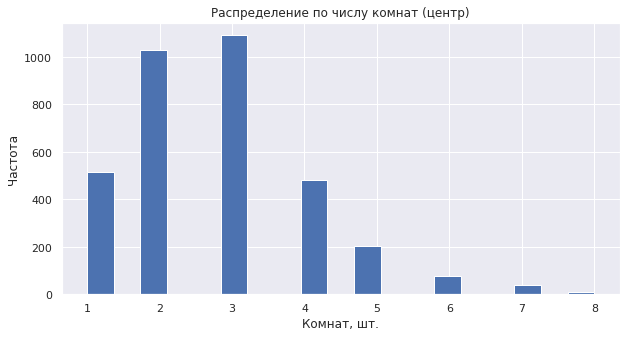

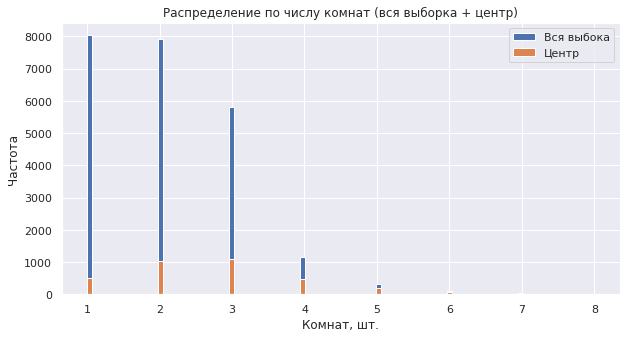

In [31]:
display(spb_center['rooms'].describe())
# Построим гистограмму
hist = spb_center['rooms'].plot(kind='hist', bins=19,  figsize=(10, 5))
hist.set(xlabel='Комнат, шт.', ylabel='Частота', title='Распределение по числу комнат (центр)') 
plt.show()

# Сравним со всей выборкой
hist = good_data['rooms'].plot(kind='hist', bins=100,  figsize=(10, 5), legend = True, label='Вся выбока')
hist = spb_center['rooms'].plot(kind='hist', bins=100,  figsize=(10, 5), legend = True, label='Центр')
hist.set(xlabel='Комнат, шт.', ylabel='Частота', title='Распределение по числу комнат (вся выборка + центр)') 
plt.show()

Результат стремится к нормальному распределению, заметнее чем на всей выборке.
Большая часть значений сосредоточены между 1 и 6 комнатами, есть редкие значения на 7 и 8 комнатах.
Основной пик приходится на 2-3-х комнатные квартиры. Пики значений также сместились вправо.

<b>Изучим высоту потолков (м.):

count   3,444.00
mean        2.93
std         0.35
min         2.40
25%         2.65
50%         2.80
75%         3.12
max         4.50
Name: ceiling_height, dtype: float64

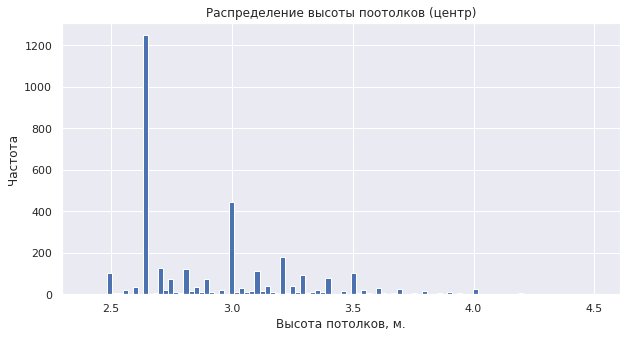

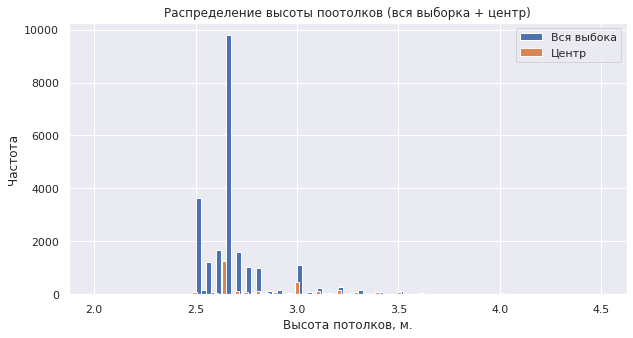

In [32]:
display(spb_center['ceiling_height'].describe())
# Построим гистограмму
hist = spb_center['ceiling_height'].plot(kind='hist', bins=100,  figsize=(10, 5))
hist.set(xlabel='Высота потолков, м.', ylabel='Частота', title='Распределение высоты поотолков (центр)') 
plt.show()

# Сравним со всей выборкой
hist = good_data['ceiling_height'].plot(kind='hist', bins=100,  figsize=(10, 5), legend = True, label='Вся выбока')
hist = spb_center['ceiling_height'].plot(kind='hist', bins=100,  figsize=(10, 5), legend = True, label='Центр')
hist.set(xlabel='Высота потолков, м.', ylabel='Частота', title='Распределение высоты поотолков (вся выборка + центр)') 
plt.show()

Большая часть значений сосредоточены между 2.5 и 4 м., есть редкие значения от 4 до 4.5 м.
Пик значений приходится на 3 м.

<b>Посмотрим на корреляцию между стоимостью квартир и кол-вом комнат.

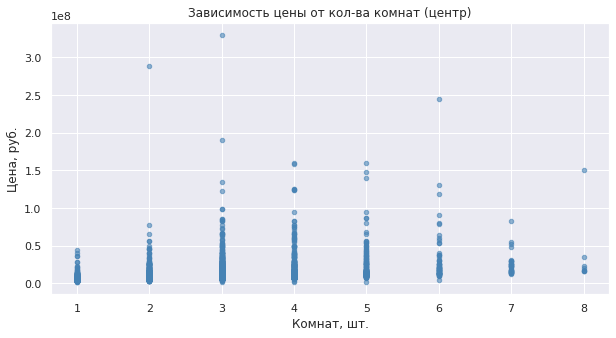

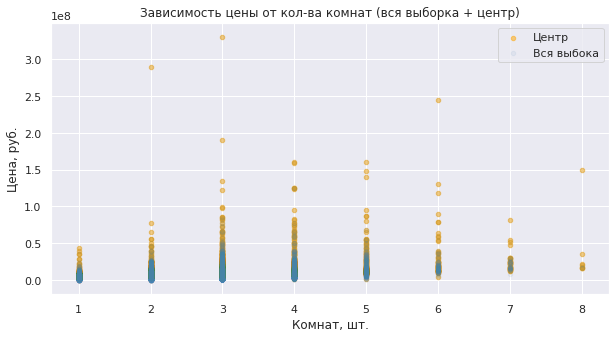

Коэффициент Пирсона в во всей выборке: 0.39279307658431245
Коэффициент Пирсона в центре: 0.31782074285922707


In [33]:
# Построим диаграмму рассеяния
scat = spb_center.plot(x = 'rooms', y = 'last_price', kind = 'scatter', figsize=(10, 5), color='steelblue', alpha=0.6) 
scat.set(xlabel='Комнат, шт.', ylabel='Цена, руб.', title='Зависимость цены от кол-ва комнат (центр)') 
plt.show()

# Сравним со всей выборкой
scat1 = spb_center.plot(x = 'rooms', y = 'last_price', kind='scatter', figsize=(10, 5), legend = True, label='Центр', color='orange', alpha=0.5)
scat2 = good_data.plot(x = 'rooms', y = 'last_price', kind='scatter', figsize=(10, 5), legend = True, label='Вся выбока', color='steelblue', alpha=0.07, ax=scat1)
scat1.set(xlabel='Комнат, шт.', ylabel='Цена, руб.', title='Зависимость цены от кол-ва комнат (вся выборка + центр)') 
plt.show()


# Посмотрим на коэффициент корреляции Пирсона
print('Коэффициент Пирсона в во всей выборке:',good_data['rooms'].corr(good_data['last_price']))
print('Коэффициент Пирсона в центре:',spb_center['rooms'].corr(spb_center['last_price']))


Некоторая низкая зависимость между ценой квартиры и кол-вом комнат обнаружена, коэффициент корреляции 0.32, ниже чем во всей выборке.

Среди 1,2,3,4,5 комнатных квартир четкая корреляция видна, однако при дальнейшем увеличении кол-ва комнат - цена, как будто, снижается. 


<b>Посмотрим на корреляцию между стоимостью квартир и удалённостью от центра.

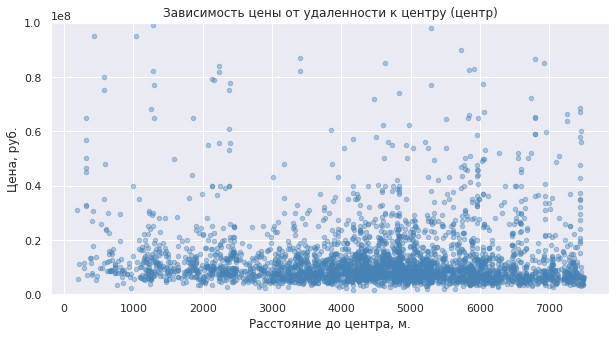

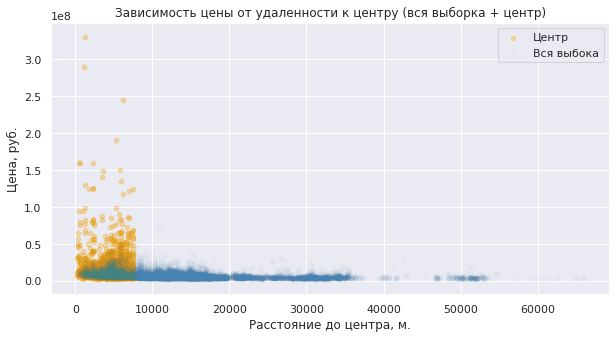

Коэффициент Пирсона в во всей выборке: -0.26121816069118636
Коэффициент Пирсона в центре: -0.05841556987614836


In [34]:
# Построим диаграмму рассеяния
scat = spb_center.plot(x='city_centers_nearest', y='last_price', kind='scatter', ylim=(0,100000000), figsize=(10, 5), color='steelblue', alpha=0.4, grid=True) 
scat.set(xlabel='Расстояние до центра, м.', ylabel='Цена, руб.', title='Зависимость цены от удаленности к центру (центр)') 
plt.show()

# Сравним со всей выборкой
scat1 = spb_center.plot(x = 'city_centers_nearest', y = 'last_price', kind='scatter', figsize=(10, 5), legend = True, label='Центр', color='orange', alpha=0.3)
scat2 = good_data.plot(x = 'city_centers_nearest', y = 'last_price', kind='scatter', figsize=(10, 5), legend = True, label='Вся выбока', color='steelblue', alpha=0.02, ax=scat1)
scat1.set(xlabel='Расстояние до центра, м.', ylabel='Цена, руб.', title='Зависимость цены от удаленности к центру (вся выборка + центр)') 
plt.show()

# Посмотрим на коэффициент корреляции Пирсона
print('Коэффициент Пирсона в во всей выборке:',good_data['city_centers_nearest'].corr(good_data['last_price']))
print('Коэффициент Пирсона в центре:',spb_center['city_centers_nearest'].corr(spb_center['last_price']))

Обратная слабая корреляция между ценой квартиры и расстоянием до центра обнаружена, коэффициент корреляции -0.06, гораздо меньше чем во всей выборке.
Внутри самого центра расстояния от некоей центральной точки не играет такой роли, как на всей выборке.

<b>Посмотрим на зависимость между стоимостью квартир и типом этажа.

,floor_type,median_price,mean_price
0,Первый,"6,700,000.00","9,128,588.00"
1,Последний,"9,000,000.00","13,845,461.00"
2,Другой,"9,530,000.00","14,197,613.00"


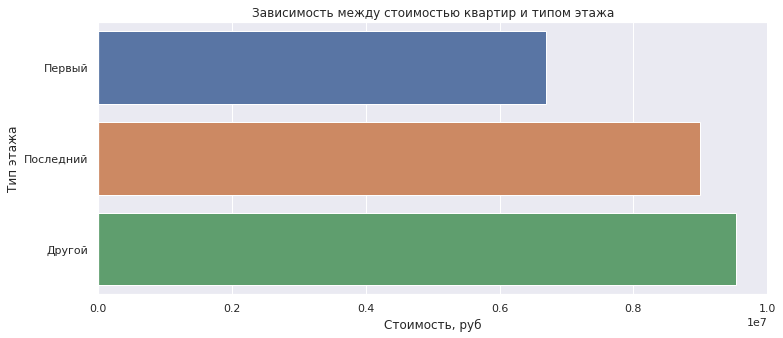

In [35]:
# Воспользуемся сводной таблицей
stat = spb_center.pivot_table(index='floor_type', values='last_price',aggfunc=['median','mean'])
stat.columns = ['median_price', 'mean_price']
display(stat.sort_values('median_price').reset_index())

bar = sb.barplot(y='floor_type',x='median_price', data=stat.sort_values('median_price').reset_index())
sb.set(rc = {'figure.figsize':(12,5)})
bar.set(xlabel='Стоимость, руб', ylabel='Тип этажа', title='Зависимость между стоимостью квартир и типом этажа')
plt.show()


По сводной таблице видно, что цена средняя цена квартир ниже всего на первом этаже. На втором месте последний этаж. Средняя стоимость на других этажах выше. 

Медианная цена по типам этажей ведет себя аналогичным образом. Ситуация такая же как на всей выборке.

<b>Посмотрим на зависимость между стоимостью квартир и дат размещения.

Посмотрим на зависимость цены от дня недели

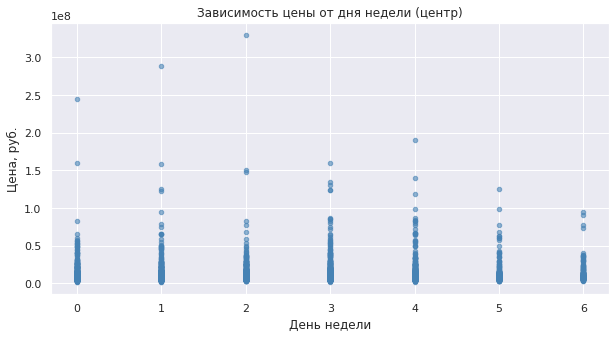

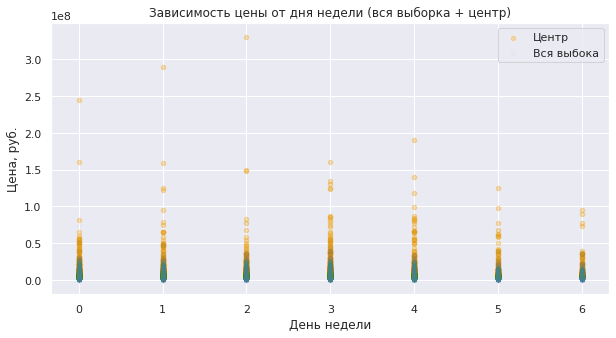

Коэффициент Пирсона в во всей выборке: -0.007986301318650734
Коэффициент Пирсона в центре: 0.004040018710831952


In [36]:
# Построим диаграмму рассеяния
scat = spb_center.plot(x='weekday', y='last_price', kind='scatter', figsize=(10, 5),color='steelblue', alpha=0.6, grid=True) 
scat.set(xlabel='День недели', ylabel='Цена, руб.', title='Зависимость цены от дня недели (центр)') 
plt.show()

# Сравним со всей выборкой
scat1 = spb_center.plot(x = 'weekday', y = 'last_price', kind='scatter', figsize=(10, 5), legend = True, label='Центр', color='orange', alpha=0.3)
scat2 = good_data.plot(x = 'weekday', y = 'last_price', kind='scatter', figsize=(10, 5), legend = True, label='Вся выбока', color='steelblue', alpha=0.02, ax=scat1)
scat1.set(xlabel='День недели', ylabel='Цена, руб.', title='Зависимость цены от дня недели (вся выборка + центр)') 
plt.show()

# Посмотрим на коэффициент корреляции Пирсона
print('Коэффициент Пирсона в во всей выборке:',good_data['weekday'].corr(good_data['last_price']))
print('Коэффициент Пирсона в центре:',spb_center['weekday'].corr(spb_center['last_price']))

Корреляция цены объявлений и дня недели отсутствует, зависимость в 2 раза ниже чем на всей выборке.

Посмотрим на зависимость цены от месяца объявления

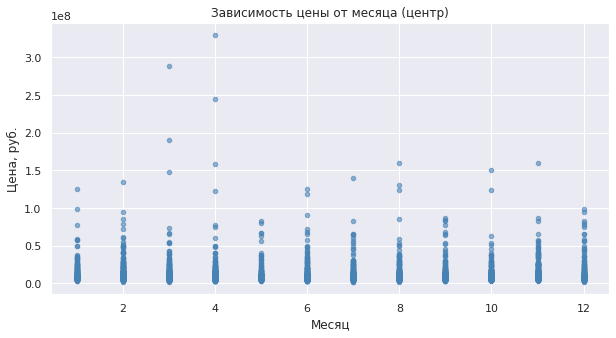

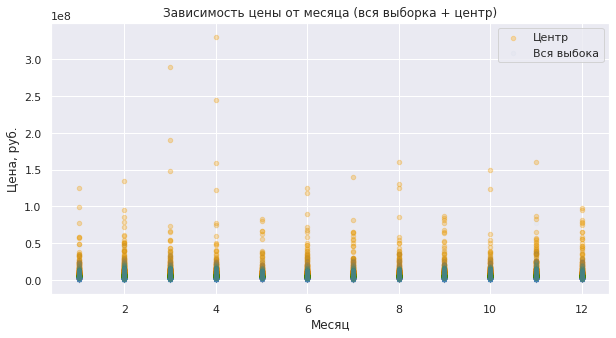

Коэффициент Пирсона в во всей выборке: 0.002787608161222048
Коэффициент Пирсона в центре: -0.010750619458326583


In [37]:
# Построим диаграмму рассеяния
scat = spb_center.plot(x='month', y='last_price', kind='scatter', figsize=(10, 5),color='steelblue', alpha=0.6, grid=True) 
scat.set(xlabel='Месяц', ylabel='Цена, руб.', title='Зависимость цены от месяца (центр)') 
plt.show()

# Сравним со всей выборкой
scat1 = spb_center.plot(x = 'month', y = 'last_price', kind='scatter', figsize=(10, 5), legend = True, label='Центр', color='orange', alpha=0.3)
scat2 = good_data.plot(x = 'month', y = 'last_price', kind='scatter', figsize=(10, 5), legend = True, label='Вся выбока', color='steelblue', alpha=0.02, ax=scat1)
scat1.set(xlabel='Месяц', ylabel='Цена, руб.', title='Зависимость цены от месяца (вся выборка + центр)') 
plt.show()

# Посмотрим на коэффициент корреляции Пирсона
print('Коэффициент Пирсона в во всей выборке:',good_data['month'].corr(good_data['last_price']))
print('Коэффициент Пирсона в центре:',spb_center['month'].corr(spb_center['last_price']))


Корреляция цены объявлений и месяца отсутствует, она еще ниже чем на всей выборке.

Посмотрим на зависимость цены от дня недели

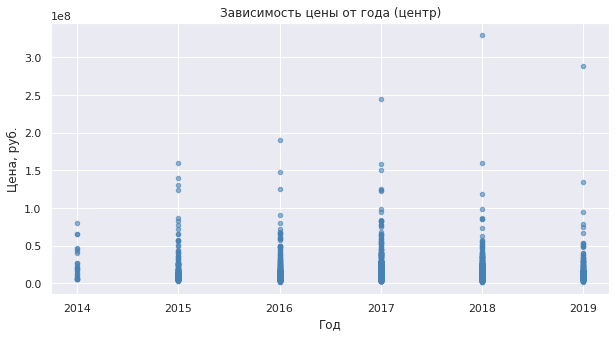

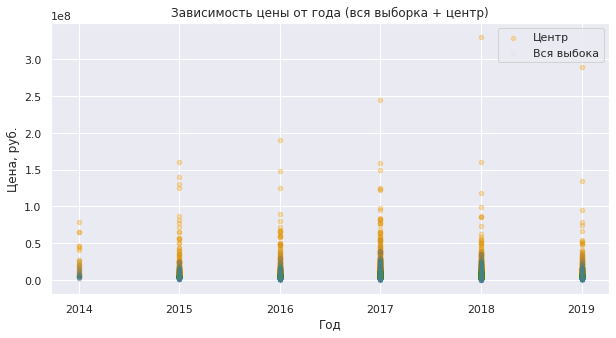

Коэффициент Пирсона в во всей выборке: -0.04729235323803907
Коэффициент Пирсона в центре: -0.052285578832352665


In [38]:
# Построим диаграмму рассеяния
scat = spb_center.plot(x='year', y='last_price', kind='scatter', figsize=(10, 5), color='steelblue', alpha=0.6, grid=True) 
scat.set(xlabel='Год', ylabel='Цена, руб.', title='Зависимость цены от года (центр)') 
plt.show()

# Сравним со всей выборкой
scat1 = spb_center.plot(x = 'year', y = 'last_price', kind='scatter', figsize=(10, 5), legend = True, label='Центр', color='orange', alpha=0.3)
scat2 = good_data.plot(x = 'year', y = 'last_price', kind='scatter', figsize=(10, 5), legend = True, label='Вся выбока', color='steelblue', alpha=0.02, ax=scat1)
scat1.set(xlabel='Год', ylabel='Цена, руб.', title='Зависимость цены от года (вся выборка + центр)') 
plt.show()

# Посмотрим на коэффициент корреляции Пирсона
print('Коэффициент Пирсона в во всей выборке:',good_data['year'].corr(good_data['last_price']))
print('Коэффициент Пирсона в центре:',spb_center['year'].corr(spb_center['last_price']))


Корреляция цены объявлений от года по прежнему отсутствует.

<a id="summary"></a>
## 5. Общий вывод

Были открыты и изучены данные о продаже квартир через Яндекс.Недвижимость в Санкт-Петербурге и Ленинградской области с 2014 по 2019 год.

* В данных предложенных для исследования были выявлены пропущенные значения в полях, заполняемых человеком, а также в вычисленных полях.
* Проведена предобработка данных, часть пропусков было заполнена исходя из логики данных.<br>
* Типы полей были изменены в соответствии с данными в них и исходя из целей экономии памяти.<br>
* В исходный датафрэйм были добавлены новые поля для послежующего анализа (цена квадратного метра; день недели, месяц и год публикации объявления; тип этажа; соотношение жилой и общей площади, а также отношение площади кухни к общей).

Был проведен исследовательский анализ данных:

1. Изучены площадь, цена, число комнат, высота потолков, время продажи квартиры. По каждому параметру построена гистограмма, выявлены медианы и средние значения, сделано общее описание графиков.

2. Выявлены выбросы и редкие значения в перечисленных выше параметрах, данные были отфильтрованы по ним и записаны в новый датафрэйм. В результате фильтрации из данных ушло всего 328 записей (около 1%), что было признано допустимым для продолжения исследования. Было проведены сравнения гистограмм до и после фильтрации.

3. Произведен факторный анализ стоимости квартир:
* Обнаружена положительная зависимость между ценой квартиры и ее площадью , коэффициент корреляции 0.68.
* Обнаружена некоторая зависимость между ценой квартиры и кол-вом комнат, коэффициент корреляции 0.39.
* Обнаружена обратная слабая корреляция между ценой квартиры и расстоянием до центра, коэффициент корреляции -0.26.
* Выявлена зависимость между средней ценой и типом этажа квартиры: Средняя цена ниже всего на первом этаже, на втором месте последний этаж, средняя стоимость на других этажах находится выше. Медианная цена по типам этажей ведет себя аналогичным образом.
* Корреляция между датами размещения объявления и ценой не выявлена.

4. Посчитана средняя цену квадратного метра в 10-ти самых встречаемых в выборке населённых пунктах. Средняя стоимость квадратного метра жилья варьируется в нашей выборке от 58 тыс.р. (Выборг) до 114 тыс.р. (Санкт-Петербург).

5. Проведен анализ изменения стоимости по удаленности от центра Санкт-Петербурга, замечено, что поведение графика резко меняется после 3х км от центра - в границах центральной зоны.

6. Был проведен повторный исследовательский анализ данных в центральной зоне Санкт-Петербурга, замечено, что графики бльше стали похожи на нормальное распределение, пики значений смещены вправо.

Повторный факторный анализ на данных по центральной зоне показал:
* снижение зависимости между ценой квартиры и кол-вом комнат: коэффициент Пирсона 0.22;
* снижение зависимости между ценой квартиры и расстоянием до центра: коэффициент Пирсона -0.19 (вероятно, внутри самого центра расстояние до некоей центральной точки не играет такой роли, как на всей выборке);
* зависимость между стоимостью и типом этажа осталась такой же, как на всей выборке;
* зависимость между стоимостью и датой размещения объявлений по прежнему осталась не выявленной.













